In [2]:
import numpy as np
import pandas as pd
import os
from sklearn.datasets import load_files
import torch
from torchvision.datasets import ImageFolder
from torchvision import models, transforms, datasets
import torchvision
import torch.nn.functional as F

number_of_classes = 120
train_dir = './fruits-360/Training'
test_dir = './fruits-360/Test'

In [19]:
# def load_dataset(path):
#     data = load_files(path)
#     files = np.array(data['filenames'])
#     targets = np.array(data['target'])
#     target_labels = np.array(data['target_names'])
#     return files,targets,target_labels

In [28]:
# # loading train data
# x_train, y_train, target_labels = load_dataset(train_dir)
# assert len(target_labels) == number_of_classes
# assert len(np.unique(y_train)) == number_of_classes

# # loading test data
# x_test, y_test, _ = load_dataset(test_dir)

In [29]:
# print('Training set size : ' , x_train.shape[0])
# print('Testing set size : ', x_test.shape[0])

Training set size :  60498
Testing set size :  20622


In [31]:
# print(y_train[0:10])
# # target labels are numbers corresponding to class label. We need to change them to a vector of 120 elements.

[  1   3  51  32  13  95  48 104  94  17]


In [3]:
transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5]) # normalize for pixel values to be between 0 and 1
])


train_data = datasets.ImageFolder(train_dir, transform=transforms)
test_data = datasets.ImageFolder(test_dir, transform=transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=300, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=300, shuffle=True)

len(trainloader.dataset)

60498

In [4]:
# y_onehot = F.one_hot(torch.from_numpy(y_train), number_of_classes)

### Visualizing the training data

In [5]:
import matplotlib.pyplot as plt

data_iter = iter(trainloader)
images, labels = data_iter.next() #pytorch automatically assigns ids to labels so they are now numbers

fig = plt.figure(figsize=(25, 5))
for idx in range(2):
    ax = fig.add_subplot(1, 5, idx + 1, xticks=[], yticks=[])
    # unnormalize first
    img = images[idx]/ 2 + 0.5
    npimg = img.numpy()
    img = np.transpose(npimg, (1, 2, 0)) #transpose
    ax.imshow(img, cmap='gray')
    ax.set_title(target_labels[labels[idx]])

NameError: name 'target_labels' is not defined

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
device

device(type='cuda')

In [8]:
model = models.resnet50(pretrained=True)
# Or you can do this in the comments to remove the fully connected layer
# modules = list(resnet.children())[:-1]      # delete the last fc layer.
# resnet = nn.Sequential(*modules)
# list(model.children())
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
import torch.nn as nn

In [10]:
for name, param in model.named_parameters():
    param.requires_grad = False

In [11]:
model.fc = nn.Linear(in_features=2048, out_features=number_of_classes, bias=True)

In [12]:
model.fc.parameters()

<generator object Module.parameters at 0x7f981c411840>

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
epochs = 3
steps = 0
running_loss = 0
print_every = 20
epoch_loss = 0
loss_values = []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad() # Zero the gradient for each batch
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        epoch_loss += loss.item() * inputs.size(0)
        if steps % print_every == 0:
            print(f"Epoch:{epoch + 1}/{epochs} Steps:{steps} Running Loss: {running_loss/print_every:.3f}")
            running_loss = 0
            model.train() #sets to training mode
    loss_values.append(epoch_loss / len(trainloader.dataset))
    epoch_loss = 0

Epoch:1/3 Steps:20 Running Loss: 499.182
Epoch:1/3 Steps:40 Running Loss: 49.309
Epoch:1/3 Steps:60 Running Loss: 18.531
Epoch:1/3 Steps:80 Running Loss: 13.208
Epoch:1/3 Steps:100 Running Loss: 8.675


KeyboardInterrupt: 

In [ ]:
torch.save(model, './checkpoints/model.pth')

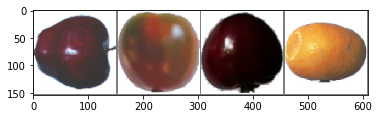

Apple Red Delicious Tomato Maroon Cherry 1 Kumquats


In [160]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[100:104]))
print(' '.join(target_labels[labels[100:104]]))

In [146]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model.forward(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total}")

Accuracy: 99.03016196295219


In [169]:
import pickle
classes = trainloader.dataset.class_to_idx

reversed_classes = {}
for key, value in classes.items():
    reversed_classes[value] = key
    
with open('classesDecoder.pkl', 'wb+') as f:
    pickle.dump(reversed_classes, f)